# Baseline Model

## Introducción
En esta notebook se implementa un modelo base de regresion logistica que servirá como referencia para evaluar futuras mejoras. El modelo base nos permitirá establecer un punto de partida y medir la efectividad de técnicas más avanzadas.


## 1. Importación de Librerías

In [76]:
# Importar las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.weightstats import ttest_ind

## 2. Configuración del Entorno

In [77]:
# Configuración de opciones de pandas
pd.set_option('display.max_columns', None)


# Configuración para reproducibilidad
np.random.seed(42)

data_dir = '../data/'
models_dir = '../models/'

## 3. Carga de Datos

In [78]:
df_train=pd.read_parquet(f'{data_dir}df_train_att.parquet')
df_test=pd.read_parquet(f'{data_dir}df_test_att.parquet')
df_val=pd.read_parquet(f'{data_dir}df_val_att.parquet')
df_vo=pd.read_parquet(f'{data_dir}df_vo_att.parquet')

df_train.shape,df_test.shape,df_val.shape,df_vo.shape

((103214, 28), (25668, 28), (32405, 28), (14223, 28))

## 4. Preparación de los Datos para el Modelo Base

In [79]:
var_modelo=['prbm_payerSalesSegment',
  'amountFinanced_log_abs_cap',
  'prbm_paymentDays',
  'expirationDays_log_abs_cap',
  'date_paymentDays_cap',
  'prbm_sector']

In [80]:
# si bien la base esta desbalanceda vamos a probar un modelo tal como es la poblacion

X_train=df_train[df_train["vd"].isin([0,1])][var_modelo]
y_train=df_train[df_train["vd"].isin([0,1])]['vd']

In [49]:
# la libreria statsmodels es  una de las mejores para realizar modelos de regresion logistca, ya que tiene estadisticos que sklear no tiene
X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.Logit(endog=y_train, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary())

Optimization terminated successfully.
         Current function value: 0.070879
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                     vd   No. Observations:               102498
Model:                          Logit   Df Residuals:                   102491
Method:                           MLE   Df Model:                            6
Date:                Sun, 08 Dec 2024   Pseudo R-squ.:                  0.4566
Time:                        20:19:43   Log-Likelihood:                -7265.0
converged:                       True   LL-Null:                       -13370.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.2004      0.285    -35.786      0.000     -10.759      -9.642
x1            14.6362      0.

In [ ]:
# se observa que todas las variables tienen valores p (P>|z|) menores a 0.05, lo cual indica que son estadísticamente significativas.
# se observa que las variable singresaron con el signo correcto

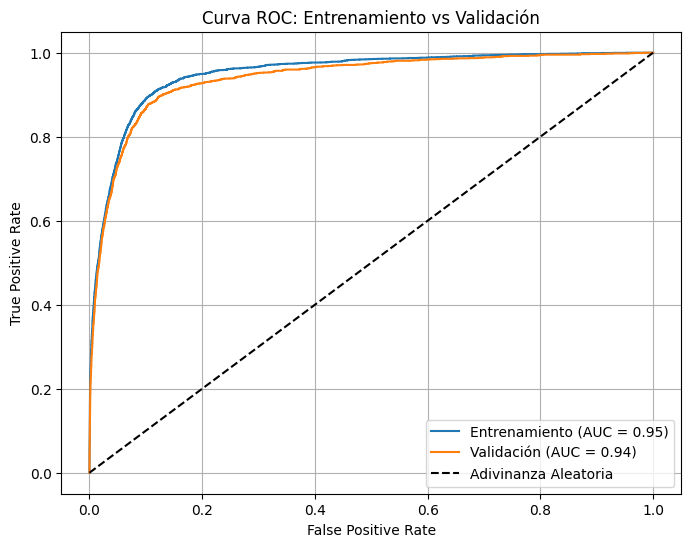

In [50]:
## se observa un modelo estable entre train y validacion con respecto a curva ROC
curva_roc(df_train,pd.concat([df_test,df_val]),modelo,variables=var_modelo,vd="vd")

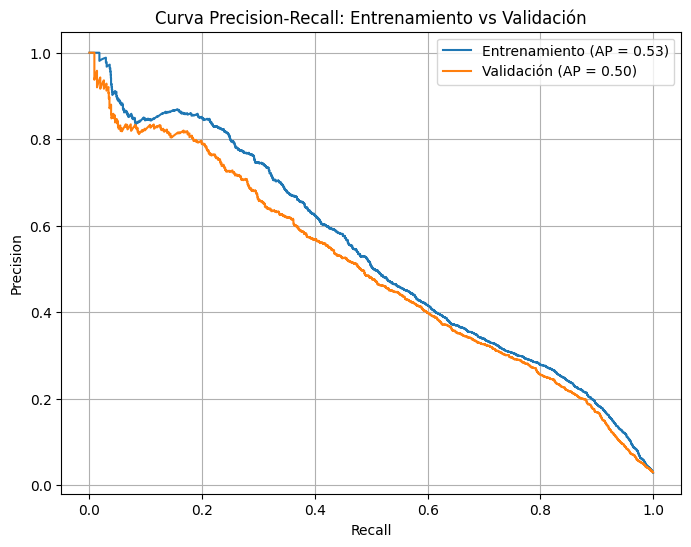

In [ ]:
## la curva precision recall se observa un modelo estable pero tiene mucho por mejorar, se necesita nuevas features para mejorar la performance

curva_precision_recall(df_train,pd.concat([df_test,df_val]),modelo,variables=var_modelo,vd="vd")

## 5. Pipeline 

In [56]:
# para el desarrollo de modelo me gusta utilizar sm , pero para llevar a produccion prefieron sklearn ya que puedo armar el pipeline

# en este pipeline se replica la misma que con sm

In [81]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

class CustomNumericalTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass


    def fit(self, X, y=None):
        return self

    def transform(self, X):
        """
        Transforma los datos aplicando la lógica personalizada.
        """


        X["prbm_payerSalesSegment"]=np.where(X["payerSalesSegment"].isin([6]),0.002391,
        np.where(X["payerSalesSegment"].isin([5]),0.020237,
        np.where(X["payerSalesSegment"].isin([3,4]),0.117108,0.190335
        )))

        X['amountFinanced']=np.where(X['amountFinanced'].isnull(),713881,X['amountFinanced'])
        X["amountFinanced_log_abs"]= np.sign(X['amountFinanced']) * np.log(np.abs(X['amountFinanced']) + 1)
        X["amountFinanced_log_abs_cap"]=X["amountFinanced_log_abs"].clip(lower=0, upper=22)

        X['date']=pd.to_datetime(X['date'])
        X['paymentDate']=pd.to_datetime(X['paymentDate'])
        X['fecha_observacion']=pd.to_datetime(X['fecha_observacion'])
        X['expirationDate']=pd.to_datetime(X['expirationDate'])

        X['paymentDays'] = np.where(X['paymentDate'].isnull(),(X['fecha_observacion'] - X['expirationDate']).dt.days, # fecha de corte "foto"
                                    (X['paymentDate'] - X['expirationDate']).dt.days)
        
        X["prbm_paymentDays"]=np.where(X["paymentDays"]<=2,0.008933,
        np.where(X["paymentDays"]<=32,0.024220,
        np.where(X["paymentDays"]<=49,0.106759,
        np.where(X["paymentDays"]<=63,0.160494,
        np.where(X["paymentDays"]<=93,0.343100,0.733679
        )))))
        


        X['expirationDays'] = (X['expirationDate'] - X['date']).dt.days
        X["expirationDays_log_abs"]= np.sign(X['expirationDays']) * np.log(np.abs(X['expirationDays']) + 1)
        X["expirationDays_log_abs_cap"]=X["expirationDays_log_abs"].clip(lower=1.79, upper=5.08)

        X['date_paymentDays']=X['expirationDays']+X['paymentDays']
        X["date_paymentDays_cap"]=X["date_paymentDays"].clip(lower=-7, upper=280)


        return X[['prbm_payerSalesSegment',
                'amountFinanced_log_abs_cap',
                'prbm_paymentDays',
                'expirationDays_log_abs_cap',
                'date_paymentDays_cap']]
    
class CustomCategoricalTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass


    def fit(self, X, y=None):
        return self

    def transform(self, X):
        """
        Transforma los datos aplicando la lógica personalizada.
        """
        sector_1=['Laboratorios y Fabricación Productos Farmacéuticos', 'Aerolíneas',
       'Suministro de Agua', 'Combustibles y Gas', 'Servicios de Salud',
       'Seguros e Isapres', 'Medios de Comunicación', 'Quimicos y Maderas']
        sector_2=['Retail', 'Ganadería', 'Acuicultura y Pesca', 'Minería y Metales']
        sector_3=['Construcción Ingeniería e Infraestructura']
        sector_4=['Hoteles, Restaurantes y Ocio', 'Agricultura y Relacionados',
            'Telecomunicaciones', 'Mercados de Capitales', 'Transporte',
            'Envíos y Almacenamiento', 'Energía', 'Relacionados a Construccion']
        sector_5=['Comercio', 'Consumo Basico', 'Servicios',
            'Tecnología de la Información', 'Gobierno y Actividades Sociales',
            'Maquinaria y Equipo','Industria Automotriz']
        sector_6=['Educación', 'Construcción de Viviendas', 'Tabaco']

        X["prbm_sector"]=np.where(X["sector"].isin(sector_1),0.000409,
        np.where(X["sector"].isin(sector_2),0.002683,
        np.where(X["sector"].isin(sector_3),0.005458,
        np.where(X["sector"].isin(sector_4),0.023589,
        np.where(X["sector"].isin(sector_5),0.050891,
        np.where(X["sector"].isin(sector_6),0.259167,0.050239
        ))))))

        return X[['prbm_sector']]
    
# Imputación para valores numéricos
numeric_transformer = Pipeline(steps=[
    ('CustomNumerical', CustomNumericalTransformer()),
])

# Imputación para valores categóricos
categorical_transformer = Pipeline(steps=[
    ('CustomCategorical', CustomCategoricalTransformer()),
])

numerical_features=['date','paymentDate','expirationDate','fecha_observacion','amountFinanced','payerSalesSegment']

categorical_features=['sector']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)



In [82]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Construir el pipeline completo
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())  
])

var_primarias=['date',
 'paymentDate',
 'expirationDate',
 'fecha_observacion',
 'amountFinanced',
 'payerSalesSegment',
 'sector']

# Entrenar el pipeline
model.fit(df_train[df_train["vd"].isin([0,1])][var_primarias],
           df_train[df_train["vd"].isin([0,1])]['vd'])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('CustomNumerical',
                                                                   CustomNumericalTransformer())]),
                                                  ['date', 'paymentDate',
                                                   'expirationDate',
                                                   'fecha_observacion',
                                                   'amountFinanced',
                                                   'payerSalesSegment']),
                                                 ('cat',
                                                  Pipeline(steps=[('CustomCategorical',
                                                                   CustomCategoricalTransformer())]),
                                                  ['sector'])])),
                ('classifier', LogisticRegression())])

In [83]:
models_dir

'../models/'

In [84]:
model.to_pickel(models_dir+'rl_model.pkl')

AttributeError: 'Pipeline' object has no attribute 'to_pickel'

In [54]:
y_pred = model.predict_proba(df_train[var_primarias])[:,1]


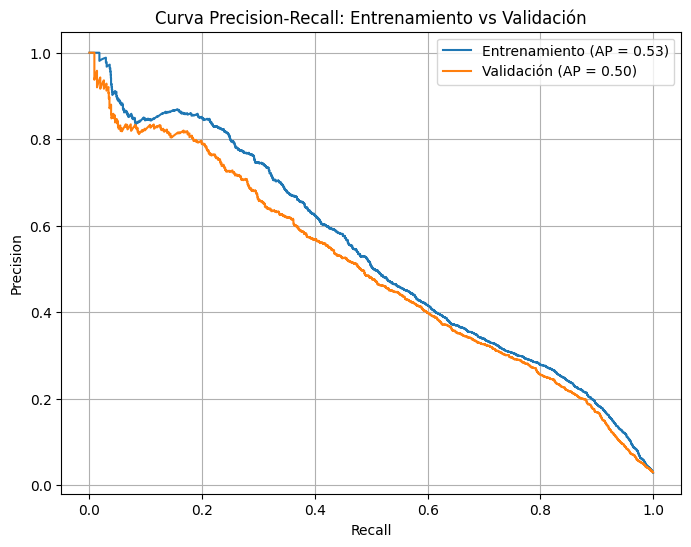

In [ ]:
## estos resultados son similar son indentico a sm

curva_precision_recall(df_train,pd.concat([df_test,df_val]),model,variables=var_primarias,vd="vd",model_sm=False)

In [58]:
df_train['score'] = (model.predict_proba(df_train[var_primarias])[:,0]*1000).round().astype(int)
df_val['score'] = (model.predict_proba(df_val[var_primarias])[:,0]*1000).round().astype(int)
df_test['score'] = (model.predict_proba(df_test[var_primarias])[:,0]*1000).round().astype(int)
df_vo['score'] = (model.predict_proba(df_vo[var_primarias])[:,0]*1000).round().astype(int)

### 5.1 desciciones 

In [59]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

Profundidad del árbol: 3
Número de nodos terminales: 6


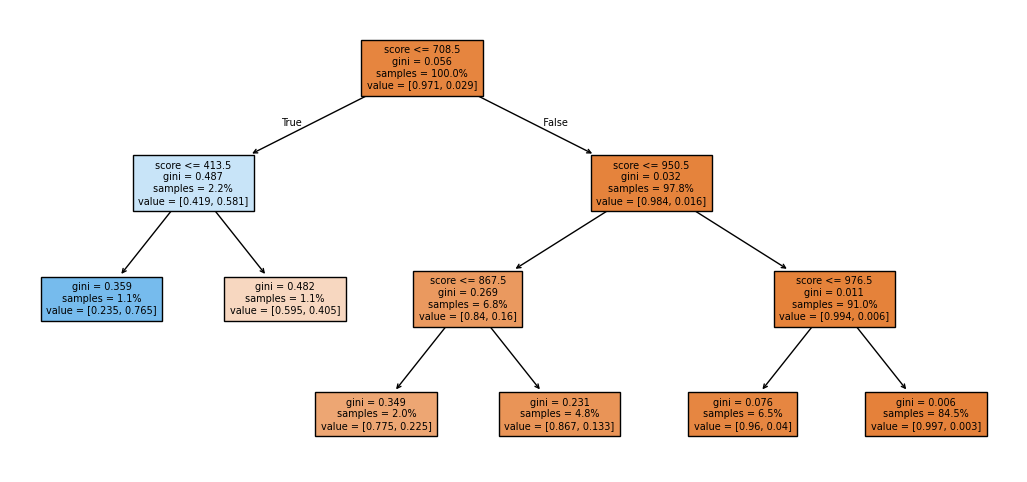

In [60]:
var='score'

X_train=df_train[df_train['vd'].isin([0,1])][[var]]
y_train=df_train[df_train['vd'].isin([0,1])]['vd']

modelo = DecisionTreeClassifier(
            max_depth         = 3,
            criterion         = 'gini',
            random_state      = 123,
            min_samples_split =0.01,
            min_samples_leaf =0.01
          )

# Entrenamiento del modelo
# ------------------------------------------------------------------------------
modelo.fit(X_train, y_train)

# Estructura del árbol creado
# Estructura del árbol creado
# ------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(13, 6))

print(f"Profundidad del árbol: {modelo.get_depth()}")
print(f"Número de nodos terminales: {modelo.get_n_leaves()}")

plot = plot_tree(
            decision_tree = modelo,
            feature_names = [var],
            #class_names   = var,
            filled        = True,
            impurity      = True,
            fontsize      = 7,
            proportion    = True,
            ax            = ax
       )

In [61]:
def decisiones(df,score='score'):
    df['decisiones']=np.where(df[score]>976,'1 - AAA',
                     np.where(df[score]>867,'2 - AA', 
                    np.where(df[score]>708,'3 - A',  
                    np.where(df[score]>413,'4 - Analiza','5 - Rechaza'))))
    
    return df['decisiones']


df_train['decisiones'] = decisiones(df_train,score='score')
df_val['decisiones'] = decisiones(df_val,score='score')
df_test['decisiones'] = decisiones(df_test,score='score')
df_vo['decisiones'] = decisiones(df_vo,score='score')

In [62]:
tabla_performance(df_train,vd,'score','decisiones')

ks 79.36 auc 95.29 gini 90.58


,score_min,score_max,total,total%,totalCum%,malos,malo%,bad_rate,bad_rateCum
decisiones,,,,,,,,,
1 - AAA,977,1000,86650,0.843884,0.843884,251,0.080166,0.002897,0.002897
2 - AA,868,976,11551,0.112495,0.956379,919,0.293516,0.079560,0.011914
3 - A,709,867,2018,0.019653,0.976032,455,0.145321,0.225471,0.016214
4 - Analiza,414,708,1175,0.011443,0.987476,481,0.153625,0.409362,0.020770
5 - Rechaza,3,413,1286,0.012524,1.000000,1025,0.327371,0.797045,0.030493


In [64]:
tabla_performance(pd.concat([df_val,df_test]),vd,'score','decisiones')

ks 77.77 auc 94.31 gini 88.62


,score_min,score_max,total,total%,totalCum%,malos,malo%,bad_rate,bad_rateCum
decisiones,,,,,,,,,
1 - AAA,977,1000,48584,0.841267,0.841267,177,0.096827,0.003643,0.003643
2 - AA,868,976,6570,0.113764,0.955031,527,0.288293,0.080213,0.012764
3 - A,709,867,1151,0.019930,0.974961,281,0.153720,0.244136,0.017494
4 - Analiza,414,707,699,0.012104,0.987065,280,0.153173,0.400572,0.022191
5 - Rechaza,4,413,747,0.012935,1.000000,563,0.307987,0.753681,0.031653


In [ ]:
# para los medelos de riesgo se suele armar decisiones y ver la estabilidad en la tabla de performance
# se observa que en termino generales es un modelo estable , para ambas base el bad rate por decision es similar 
# en rechazar tiene el 1.3% total con un badrate del 75%


In [ ]:
tabla_performance(df_vo,vd,'score','decisiones')

# esta base es super importante porque tengo un mes completo donde la tasa tasa de malo total de este mes fue de 5% (lo que indicaba de la poblacion,que se observaba una aceleracion en en la tasa de malo)
# en esta base el modelo separa bien los rechhazar y AAA. pero se podria seguir mejorando para que se tenga mayor separacion en la decisiones A y analiza



ks 92.55 auc 98.82 gini 97.64


,score_min,score_max,total,total%,totalCum%,malos,malo%,bad_rate,bad_rateCum
decisiones,,,,,,,,,
1 - AAA,977,999,10759,0.787917,0.787917,3,0.003922,0.000279,0.000279
2 - AA,868,976,1588,0.116294,0.904211,21,0.027451,0.013224,0.001944
3 - A,709,867,406,0.029733,0.933944,89,0.116340,0.219212,0.008861
4 - Analiza,415,706,201,0.014720,0.948663,87,0.113725,0.432836,0.015439
5 - Rechaza,2,413,701,0.051337,1.000000,565,0.738562,0.805991,0.056023


### 5.2 Importancia Variables 

In [66]:
import shap


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [67]:
df_tranf=model.named_steps['preprocessor'].transform(df_train[var_primarias])

In [70]:
modelo_clf=model.named_steps['classifier']

var_modelo=['prbm_payerSalesSegment',
  'amountFinanced_log_abs_cap',
  'prbm_paymentDays',
  'expirationDays_log_abs_cap',
  'date_paymentDays_cap',
  'prbm_sector']

clf_exp=shap.Explainer(
    modelo_clf,
    df_tranf,
    feature_names=var_modelo
    
)

shap_exp_values_clf=clf_exp(df_tranf)

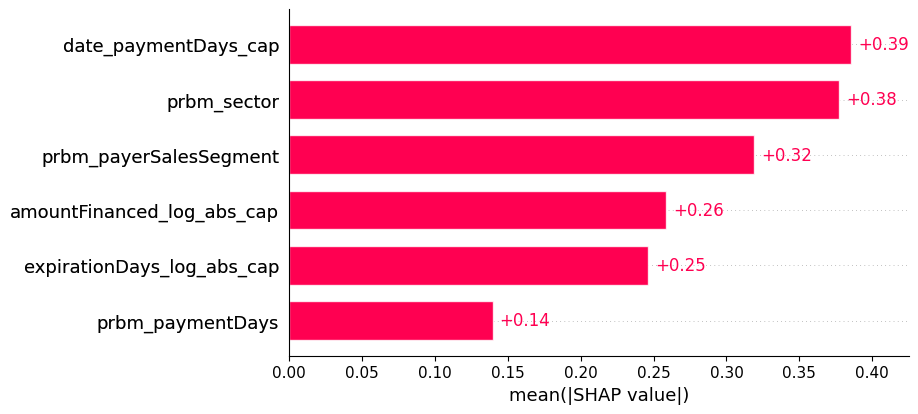

In [71]:
shap.plots.bar(shap_exp_values_clf)

In [ ]:
## La variable mas importante mediante la tecnica shap value es date_paymentDays_cap y prbm_sector

# donde 
# date_paymentDays_cap es los dias desde la generacion de la factura hasta el pago o fecha de observacion 
# prbm_sector es la probabilidad de malo de grupos de sector

### 5.3 Simulaciones

In [73]:
var_plot=['prbm_payerSalesSegment',
  'amountFinanced_log_abs_cap',
  'prbm_paymentDays',
  'expirationDays_log_abs_cap',
  'date_paymentDays_cap',
  'prbm_sector']

In [74]:
X_preprocessor=pd.DataFrame(model.named_steps['preprocessor'].transform(df_train[var_primarias].sample(n=500)),columns=var_plot)
modelo_classifier=model.named_steps['classifier']
X_preprocessor.head()

,prbm_payerSalesSegment,amountFinanced_log_abs_cap,prbm_paymentDays,expirationDays_log_abs_cap,date_paymentDays_cap,prbm_sector
0,0.020237,16.138315,0.008933,4.143135,62.0,0.002683
1,0.020237,14.637614,0.008933,3.218876,22.0,0.002683
2,0.002391,12.948462,0.008933,3.526361,28.0,0.002683
3,0.020237,10.643924,0.008933,4.060443,50.0,0.259167
4,0.020237,10.824845,0.024220,4.418841,92.0,0.005458


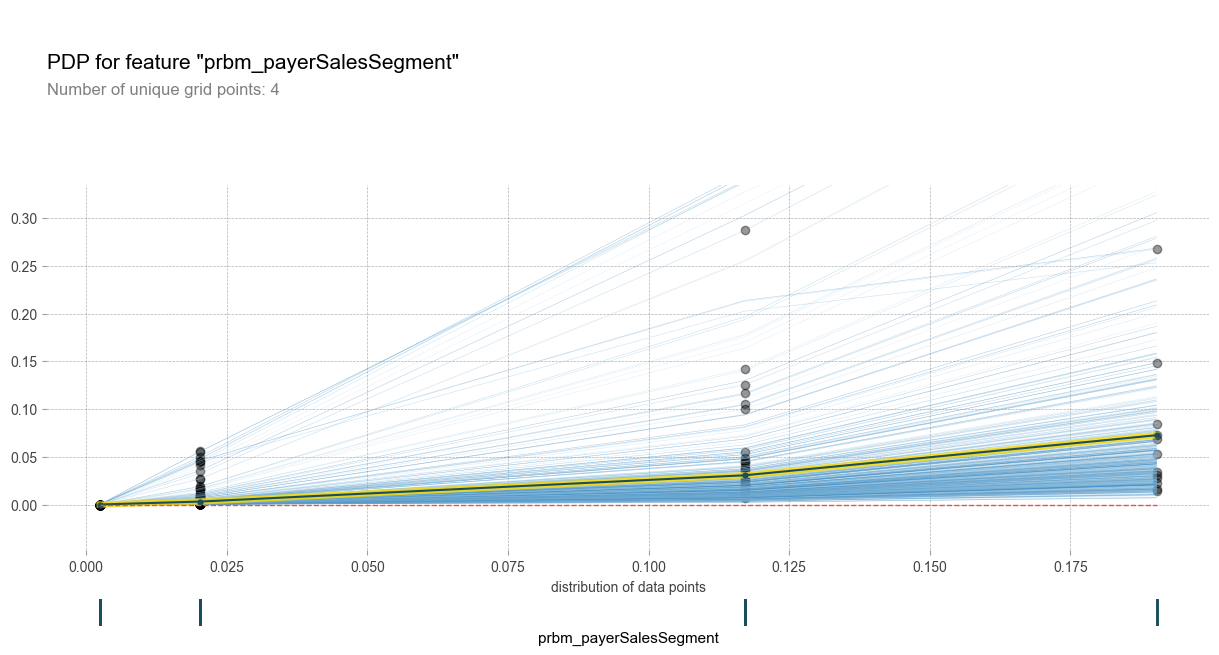

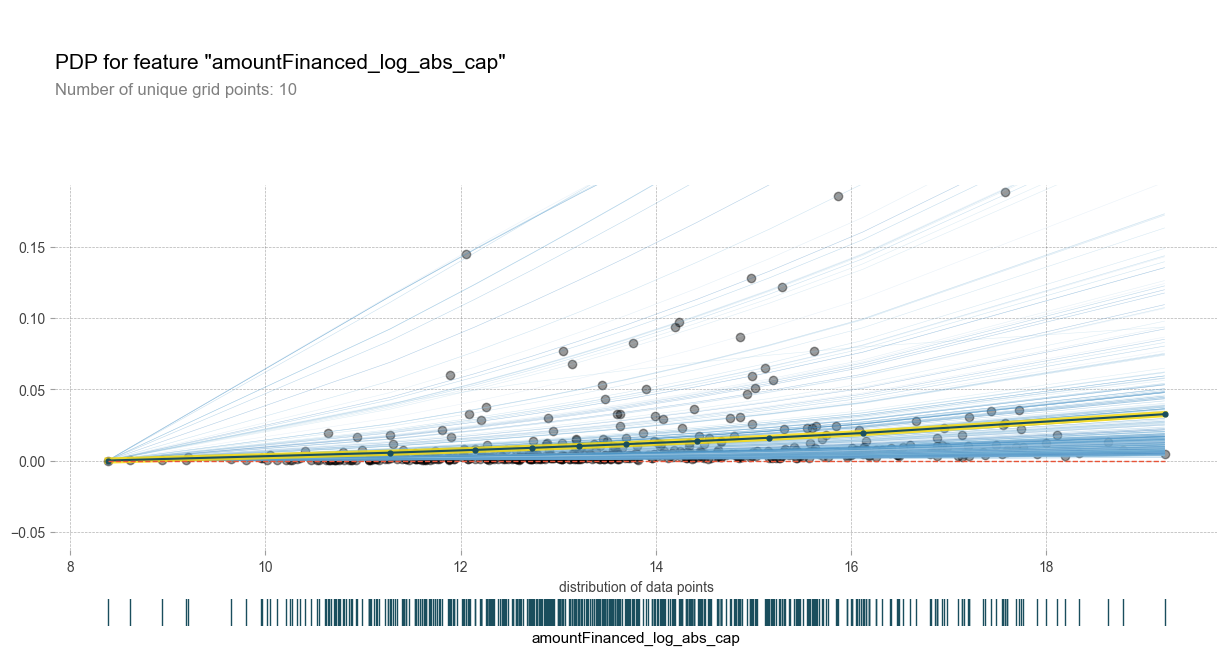

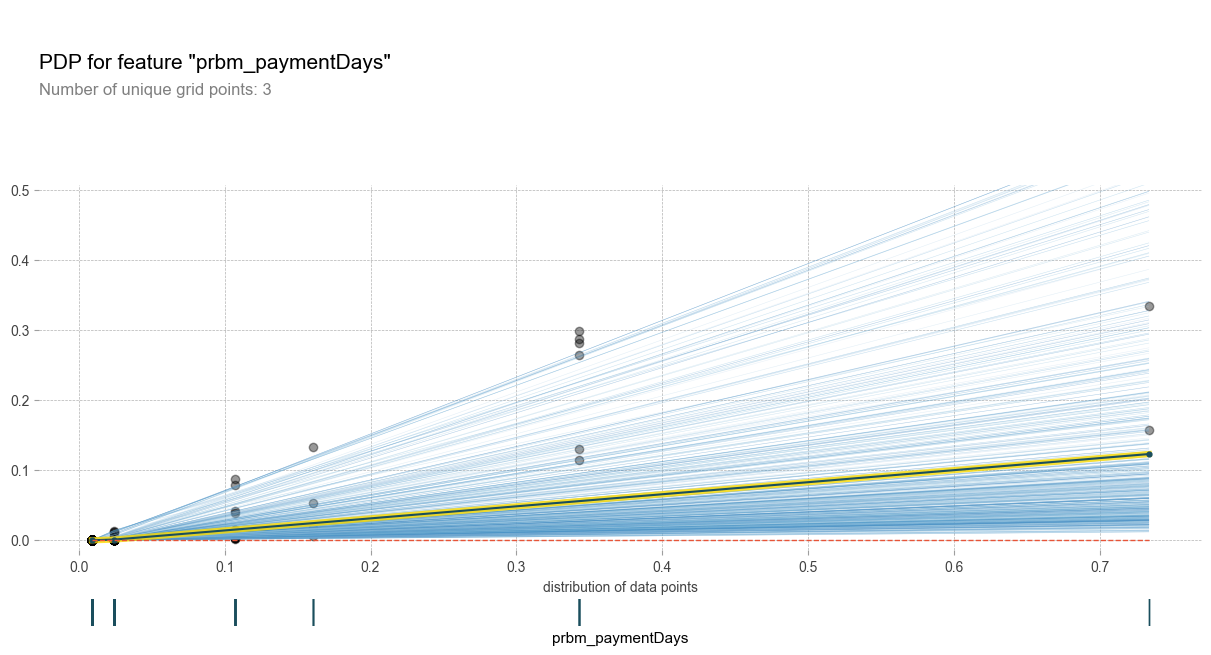

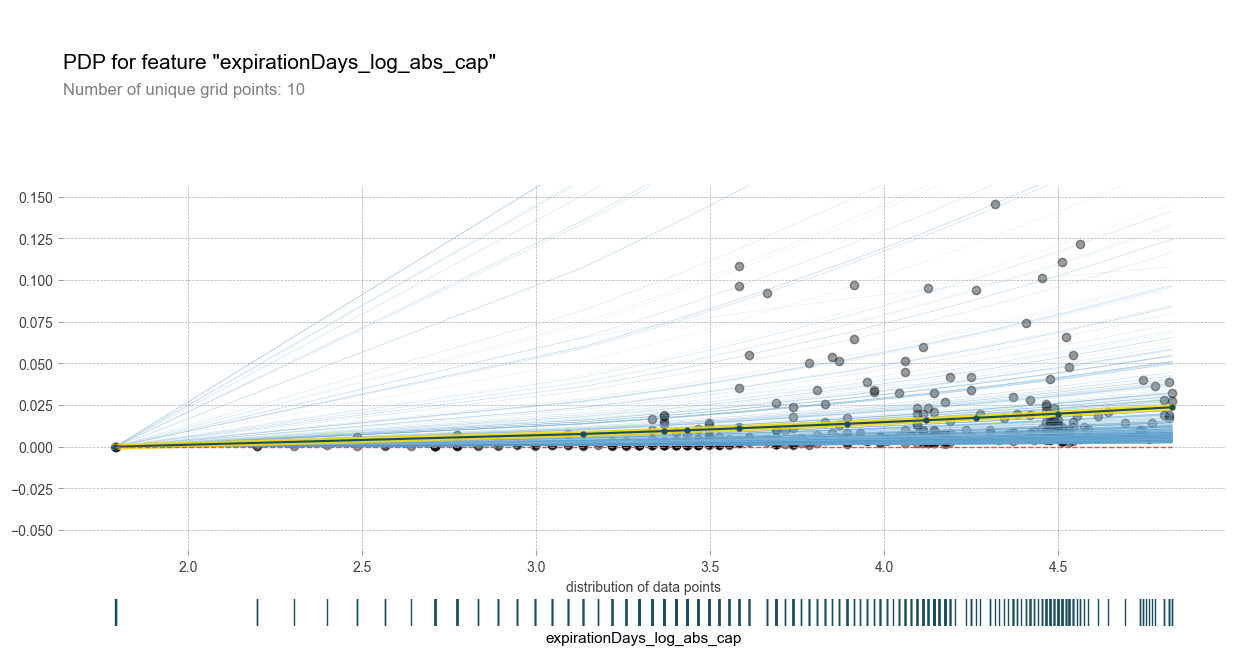

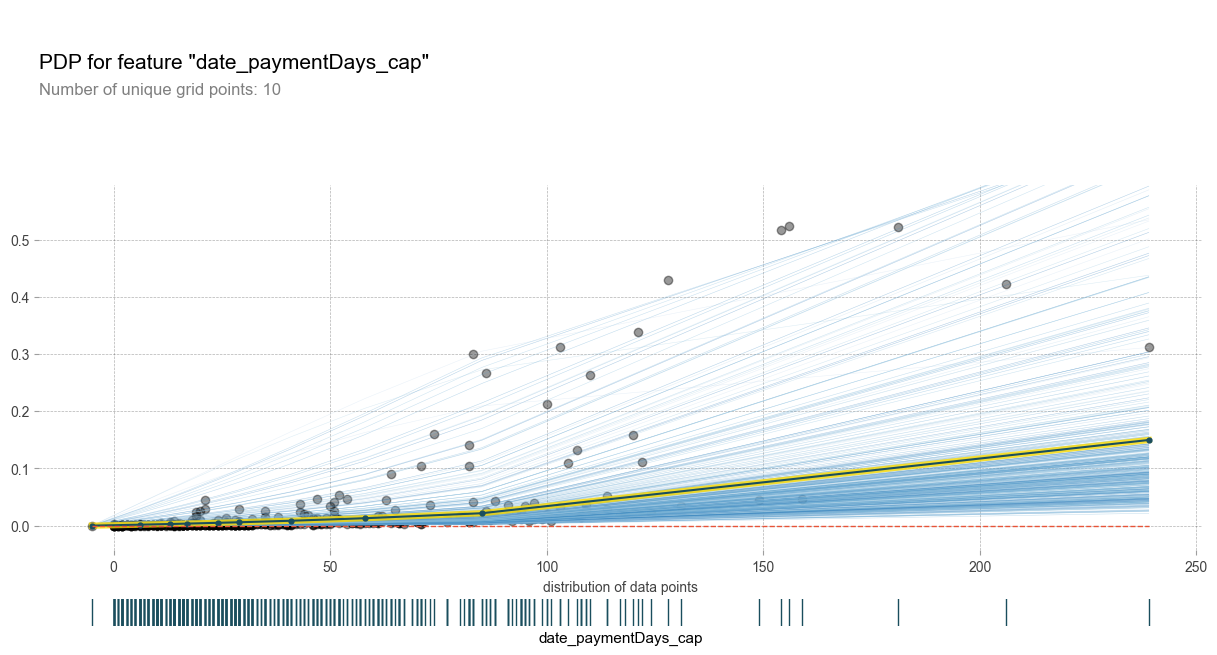

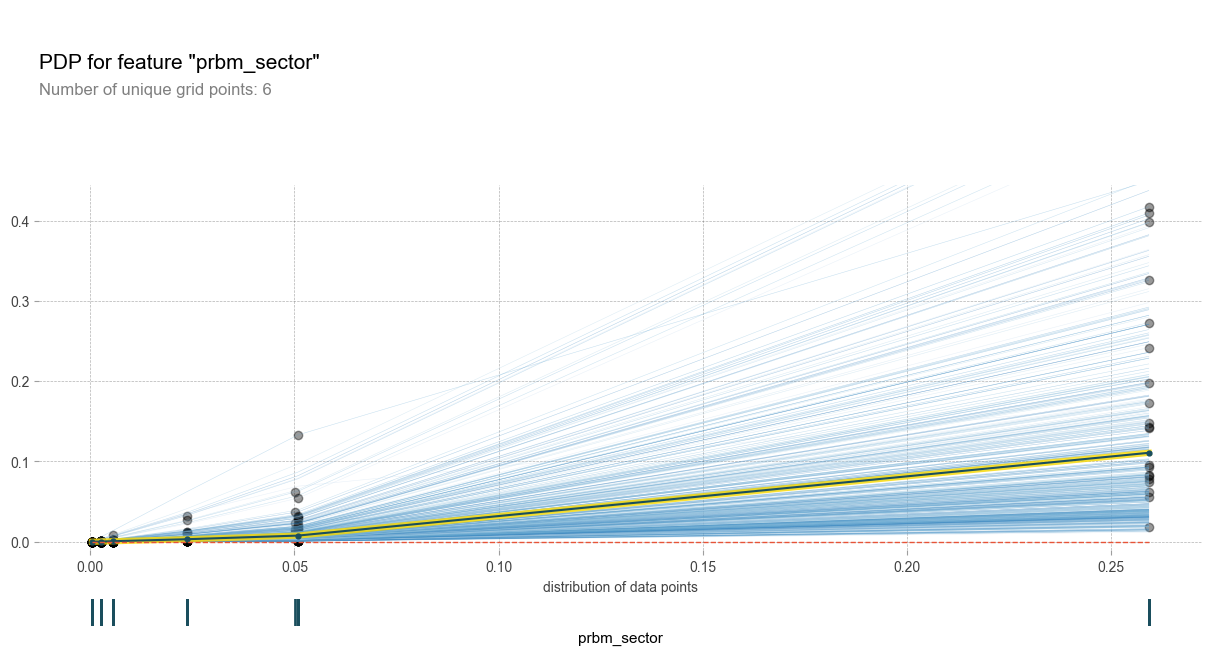

In [75]:
from pdpbox import pdp
import warnings
import numpy as np
import matplotlib.pyplot as plt

# Desactivar las advertencias sobre la fuente 'Arial'
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")


var_plot=['prbm_payerSalesSegment',
  'amountFinanced_log_abs_cap',
  'prbm_paymentDays',
  'expirationDays_log_abs_cap',
  'date_paymentDays_cap',
  'prbm_sector']

varsstep=var_plot

# Iterar sobre las variables a analizar
for var_analisis in var_plot:


    # Cálculo de las curvas ICE (Individual Conditional Expectation)
    ice_df = pdp.pdp_isolate(
        model=modelo_classifier,
        dataset=X_preprocessor,
        feature=var_analisis,
        model_features=varsstep,
        grid_type="percentile",  # Tipo de discretización de los puntos
    )

    # Generación del gráfico PDP
    fig, axes = pdp.pdp_plot(
        ice_df,
        feature_name=var_analisis,
        center=True,
        plot_pts_dist=True,
        plot_lines=True,
        frac_to_plot=1,
        x_quantile=False,
        show_percentile=False,
        figsize=(15, 8),
        ncols=2,
        which_classes=None,
        #plot_params=plot_params,
    )

    # Agregar scatter de puntos reales versus diferencias de predicción
    axes["pdp_ax"]["_pdp_ax"].scatter(
        X_preprocessor[var_analisis],
        modelo_classifier.predict_proba(X_preprocessor)[:, 1] -
        ice_df.ice_lines.transpose().iloc[0, :],
        color="k",
        alpha=0.4,
    )

    # Mostrar los gráficos
    plt.show()


In [ ]:
## Se observa en los graficos que las variables tienen el signo correcto expirationDays_log_abs_cap a medida que aumenta se observa que tiene mayor probabilidad de caer en default ,

## 6. Conclusiones modelo base

1. **Desbalanceo en la población:**
   - Aunque la base de datos está desbalanceada, se decidió entrenar el modelo manteniendo la proporción original de la población para reflejar mejor la realidad del negocio.

2. **Uso de `statsmodels` para modelado inicial:**
   - La librería `statsmodels` fue utilizada debido a su capacidad para ofrecer estadísticos detallados, como los valores p, que no están disponibles en `sklearn`.
   - Todas las variables seleccionadas tienen valores p (P>|z|) menores a 0.05, lo que indica que son estadísticamente significativas.
   - Las variables ingresaron con el signo esperado, lo que refuerza la coherencia del modelo.

3. **Evaluación del modelo:**
   - **Curva ROC:** Se observa estabilidad entre las bases de entrenamiento y validación, con un buen desempeño discriminativo.
   - **Curva Precision-Recall:** Aunque se observa estabilidad, la performance podría mejorar con la incorporación de nuevas características.

4. **Producción del modelo con `sklearn`:**
   - Para llevar el modelo a producción, se replicó el pipeline utilizando `sklearn`.
   - Los resultados obtenidos son idénticos a los de `statsmodels`, asegurando la consistencia del proceso.

5. **Estabilidad del modelo:**
   - Se analizó la estabilidad mediante tablas de performance y la distribución de decisiones:
     - En ambas bases (entrenamiento y validación), el `bad rate` por decisión es similar, indicando que el modelo es estable.
     - La categoría de "rechazar" representa el 1.3% del total con un `bad rate` del 75%, destacando su capacidad para identificar correctamente a los malos pagadores.
   - La base del mes completo utilizada para prueba tiene una tasa de malo total del 5%, alineada con la aceleración observada en la población.
   - El modelo separa bien las decisiones de "rechazar" y "AAA". Sin embargo, existe margen para mejorar la separación entre las categorías "A" y "analizar".

6. **Variables más importantes (SHAP Values):**
   - Según el análisis con SHAP Values, las variables más relevantes son:
     - **`date_paymentDays_cap`:** Representa los días desde la generación de la factura hasta el pago o fecha de observación.
     - **`prbm_sector`:** Probabilidad de malo calculada a nivel de grupos sectoriales.
   - Ambas variables tienen un impacto significativo y ayudan a explicar las predicciones del modelo.

7. **Análisis mediante gráficos PDP:**
   - Los gráficos PDP muestran que las variables tienen el signo correcto:
     - Por ejemplo, **`expirationDays_log_abs_cap`:** A medida que aumenta, la probabilidad de default también incrementa, lo que es consistente con las expectativas del negocio.

8. **Conclusión general:**
   - El modelo base es estable y muestra un desempeño sólido en identificar malos pagadores. 
   - Sin embargo, la performance podría mejorarse mediante la incorporación de nuevas características y un enfoque más refinado para mejorar la separación entre decisiones "A" y "analizar".

---

Este modelo base establece un punto de partida sólido para iteraciones futuras, permitiendo construir un sistema más robusto y eficiente.






In [13]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
def curva_roc(dev,val,modelo,variables=var_modelo,vd="vd",model_sm=True):
    
    y_train=dev[dev[vd].isin([0,1])][vd]
    y_valid=val[val[vd].isin([0,1])][vd]

    if model_sm:
        X_dev=sm.add_constant(dev[dev[vd].isin([0,1])][variables], prepend=True)
        X_val=sm.add_constant(val[val[vd].isin([0,1])][variables], prepend=True)

        y_train_scores=modelo.predict(exog = X_dev)
        y_valid_scores=modelo.predict(exog = X_val)
    else:

        y_train_scores=modelo.predict_proba(dev[dev[vd].isin([0,1])][variables])[:,1]
        y_valid_scores=modelo.predict_proba(val[val[vd].isin([0,1])][variables])[:,1]

    # Calcular la curva ROC
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_scores)
    roc_auc_train = roc_auc_score(y_train, y_train_scores)

    # Curva ROC para validación
    fpr_valid, tpr_valid, _ = roc_curve(y_valid, y_valid_scores)
    roc_auc_valid = roc_auc_score(y_valid, y_valid_scores)

    # Graficar la curva ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_train, tpr_train, label=f"Entrenamiento (AUC = {roc_auc_train:.2f})")
    plt.plot(fpr_valid, tpr_valid, label=f"Validación (AUC = {roc_auc_valid:.2f})")
    plt.plot([0, 1], [0, 1], 'k--', label="Adivinanza Aleatoria")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Curva ROC: Entrenamiento vs Validación")
    plt.legend()
    plt.grid()
    plt.show()

from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
def curva_precision_recall(dev,val,modelo,variables=var_modelo,vd="vd",model_sm=True):
    
    y_train=dev[dev[vd].isin([0,1])][vd]
    y_valid=val[val[vd].isin([0,1])][vd]

    if model_sm:

        X_dev=sm.add_constant(dev[dev[vd].isin([0,1])][variables], prepend=True)
        X_val=sm.add_constant(val[val[vd].isin([0,1])][variables], prepend=True)

        y_train_scores=modelo.predict(exog = X_dev)
        y_valid_scores=modelo.predict(exog = X_val)
    else:

        y_train_scores=modelo.predict_proba(dev[dev[vd].isin([0,1])][variables])[:,1]
        y_valid_scores=modelo.predict_proba(val[val[vd].isin([0,1])][variables])[:,1]


    # Calcular la curva ROC
    precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_scores)
    ap_train = average_precision_score(y_train, y_train_scores)

    # Curva Precision-Recall para validación
    precision_valid, recall_valid, _ = precision_recall_curve(y_valid, y_valid_scores)
    ap_valid = average_precision_score(y_valid, y_valid_scores)

    # Graficar la curva ROC
    plt.figure(figsize=(8, 6))
    plt.plot(recall_train, precision_train, label=f"Entrenamiento (AP = {ap_train:.2f})")
    plt.plot(recall_valid, precision_valid, label=f"Validación (AP = {ap_valid:.2f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Curva Precision-Recall: Entrenamiento vs Validación")
    plt.legend()
    plt.grid()
    plt.show()    

vd='vd'
score="score"
desciones='payerSalesSegment'

from sklearn.metrics import roc_curve, roc_auc_score

def tabla_performance(df,vd,score,desciones):

    df=df[df[vd].isin([0,1,2])].copy()
    df['vd']=np.where(df[vd]==2,1,df[vd])

    df = df.sort_values(by=score, ascending=True)

    df['cum_bad'] = df[vd].cumsum() / df[vd].sum()
    df['cum_good'] = (1 - df[vd]).cumsum() / (1 - df[vd]).sum()
    df['ks'] = df['cum_bad'] - df['cum_good']


    ks_value = round(df['ks'].max()*100,2)
    auc = round(roc_auc_score(df[vd], 1000-df[score])*100,2)
    gini = round((2 * auc/100 - 1)*100,2)

    print(f"ks {ks_value}",f"auc {auc}",f"gini {gini}")


    df_tmp=df.groupby([desciones]).agg(
        score_min=(score,'min'),
        score_max=(score,'max'),
        malos=(vd,'sum'),
        total=(vd,'size'),
    )
    df_tmp["bad_rate"]=df_tmp["malos"]/df_tmp["total"]
    df_tmp["malo%"]=df_tmp["malos"]/df_tmp["malos"].sum()
    df_tmp["maloCum"]=df_tmp['malos'].cumsum()

    df_tmp["total%"]=df_tmp["total"]/df_tmp["total"].sum()
    df_tmp["totalCum"]=df_tmp['total'].cumsum()
    df_tmp["totalCum%"]=df_tmp['total%'].cumsum()
    df_tmp["bad_rateCum"]=df_tmp["maloCum"]/df_tmp["totalCum"]

    return df_tmp[["score_min","score_max",'total','total%',"totalCum%",'malos',"malo%",'bad_rate','bad_rateCum']]